## Predicting Price with Size, Location, and Neighborhood

**Goal: Use all features in the dataset to improve the model for predicting the price of a house in Bueno Aires.** 

Specific Goals:

- Build a model to predict apartment price
- Evaluate all the features in the dataset for use in the model.
- Create two deployments of the trained model

Specifics:
1. Prepare Data

 A. Import: Wrangle function & list comprehension.

 B. Explore: Null values, high - and low-cardinality, leakage, multicollinearity.

 C. Split. 

2. Build model

3. Communicate Results.

 A. make_prediction function
 
 B. Interactive dashboard MVP

In [7]:
import warnings
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

from sklearn.impute import  SimpleImputer
from sklearn.linear_model import  LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

#### 1. Prepare Data

##### Import


In [81]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop columns with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)

    # Drop low and high cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=['price',
                        'price_aprox_local_currency',
                        'price_per_m2',
                        'price_usd_per_m2'], 
                        inplace=True)
    
    # drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

Use glob to collect names

In [62]:
files = glob("data/buenos-aires-real-estate*.csv")
files

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv',
 'data\\buenos-aires-real-estate-3.csv',
 'data\\buenos-aires-real-estate-4.csv',
 'data\\buenos-aires-real-estate-5.csv']

In [33]:
# Assertion
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

Wrangle With List Comprehension

In [82]:
frames = [wrangle(file) for file in files]
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [35]:
# Assertion
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

Concatenate DataFrames

In [83]:
df = pd.concat(frames)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6582 entries, 4 to 8597
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 308.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [25]:
# Assertion
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 17, f"`df` has too many columns: {df.shape[1]}"

In [29]:
# How many NaN are in each column
df.isnull().sum()

operation                        0
property_type                    0
price                            0
currency                         0
price_aprox_local_currency       0
price_aprox_usd                  0
surface_total_in_m2           1830
surface_covered_in_m2            0
price_usd_per_m2              2046
price_per_m2                     0
floor                         4682
rooms                         1296
expenses                      4843
properati_url                    0
lat                            266
lon                            266
neighborhood                     0
dtype: int64

In [30]:
# What proportion is null
df.isnull().sum()/len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.278031
surface_covered_in_m2         0.000000
price_usd_per_m2              0.310848
price_per_m2                  0.000000
floor                         0.711334
rooms                         0.196901
expenses                      0.735795
properati_url                 0.000000
lat                           0.040413
lon                           0.040413
neighborhood                  0.000000
dtype: float64

Generally, if a column has more than 50% missing values, it is appropriate to drop them. We do this is ```wrangle``` function to drop "floor" and "expenses".

In [40]:
# What proportion is null
df.isnull().sum()/len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.278031
surface_covered_in_m2         0.000000
price_usd_per_m2              0.310848
price_per_m2                  0.000000
rooms                         0.196901
properati_url                 0.000000
lat                           0.040413
lon                           0.040413
neighborhood                  0.000000
dtype: float64

In [42]:
# Assertion
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 15, f"`df` has too many columns: {df.shape[1]}"

Low-And High-Cardinality Categoriacal Features

In [45]:
# Select categorical features
df.select_dtypes("object").head()

,operation,property_type,currency,properati_url,neighborhood
4,sell,apartment,USD,http://chacarita.properati.com.ar/10qlv_venta_...,Chacarita
9,sell,apartment,USD,http://villa-luro.properati.com.ar/12m82_venta...,Villa Luro
29,sell,apartment,USD,http://caballito.properati.com.ar/11wqh_venta_...,Caballito
40,sell,apartment,USD,http://constitucion.properati.com.ar/k2f0_vent...,Constitución
41,sell,apartment,USD,http://once.properati.com.ar/suwa_venta_depart...,Once


In [46]:
# How many unique features in each column?
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            2
properati_url    6582
neighborhood       57
dtype: int64

Those with 1 unique values can be considered as constants (low-cardinality categorical features), and it is best practice to drop them before training the model.

High-cardinality also don't give useful information to the model (information overload). propertyy_url, for example is unique for every obsersation.

In [58]:
# Assertion
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 11, f"`df` has too many columns: {df.shape[1]}"

Leakage

Leaky features: Give the model the information it would not have if the model was deployed in the real-world - the information that the model shouldn't have access to.

In [60]:
# Examining the columns
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [68]:
# Assertion
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 7, f"`df` has too many columns: {df.shape[1]}"

In [69]:
df.head()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon,neighborhood
4,129000.0,76.0,70.0,NaN,-34.584651,-58.454693,Chacarita
9,87000.0,48.0,42.0,NaN,-34.638979,-58.500115,Villa Luro
29,118000.0,NaN,54.0,2.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,42.0,2.0,-34.625222,-58.382382,Constitución
41,90000.0,57.0,50.0,3.0,-34.610610,-58.412511,Once


Multicollinearity Heatmap

In [76]:
# Correlation matrix
corr = round(df.select_dtypes("number").drop(columns="price_aprox_usd").corr(), 4)
corr

,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
surface_total_in_m2,1.0000,0.7357,0.5964,0.0704,0.0190
surface_covered_in_m2,0.7357,1.0000,0.7850,0.0285,0.0345
rooms,0.5964,0.7850,1.0000,-0.0486,0.0304
lat,0.0704,0.0285,-0.0486,1.0000,-0.2624
lon,0.0190,0.0345,0.0304,-0.2624,1.0000


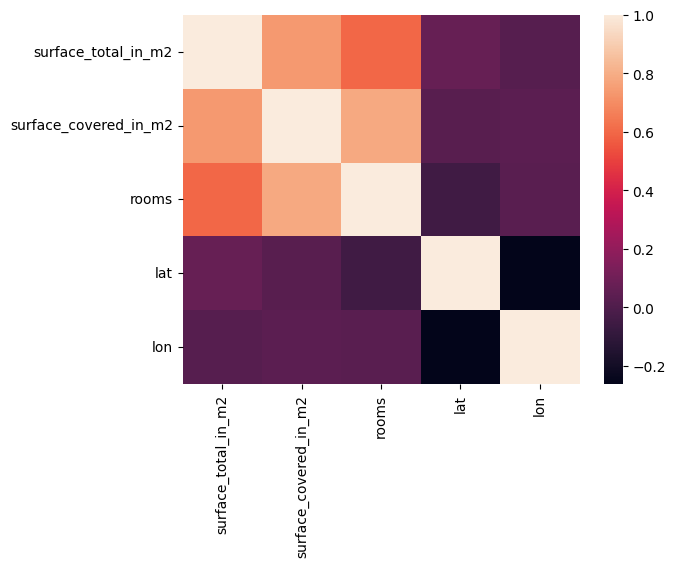

In [78]:
sns.heatmap(corr);

The 3 features that are highly correlated: rooms, surface_covered_in_m2 and surface_total_in_m2

In [80]:
# Lets keep the ones that have least missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6582 entries, 4 to 8597
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 411.4+ KB


In [ ]:
# new correlation matrix after removing columns with multicollineaity


##### Explore

Identify and Drop Null Values

##### Split

#### 2. Building Model

##### Baseline

##### Iterate

 ##### Evaluate

#### 3. Communicate Results